# Training our Fruit Classifer
### Experimenting with Callbacks
- Let's create our data generators

In [1]:
!pip install kaggle

In [0]:
!mkdir .kaggle

In [0]:
import json

In [7]:
token = {“username”:”akshaylucof”,”key”:”2ba90f5960ccb38c72cb2615892af210”}


SyntaxError: ignored

In [0]:
token={"username":"akshaylucof","key":"2ba90f5960ccb38c72cb2615892af210"}

In [0]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [25]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [28]:
!kaggle datasets download -d moltean/fruits

 98% 720M/732M [00:19<00:00, 45.2MB/s]
100% 732M/732M [00:19<00:00, 38.6MB/s]


In [36]:
!unzip /content/{/content}/datasets/moltean/fruits/fruits.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/fruits-360/Training/Tangelo/r_16_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_17_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_181_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_182_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_183_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_184_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_185_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_186_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_187_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_188_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_189_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_18_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_190_100.jpg  
  inflating: /content/fruits-360/Training/Tangelo/r_191_100.jpg  
  inflating: /content/fruits

In [29]:
pwd


'/content'

In [39]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = 120
img_rows, img_cols = 32, 32
batch_size = 64

from keras.preprocessing.image import ImageDataGenerator

train_data_dir = './fruits-360/Training'
validation_data_dir = './fruits-360/Test'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 60486 images belonging to 120 classes.
Found 20618 images belonging to 120 classes.


### Let's define our model

In [40]:
model = Sequential()

# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)       

In [41]:
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("/content/fruits_fresh_cnn_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 41322
nb_validation_samples = 13877
epochs = 10

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
645/645 [==============================] - 225s 349ms/step - loss: 3.0165 - accuracy: 0.2049 - val_loss: 0.7151 - val_accuracy: 0.6424

Epoch 00001: val_loss improved from inf to 0.71508, saving model to /content/fruits_fresh_cnn_1.h5
Epoch 2/10
645/645 [==============================] - 227s 352ms/step - loss: 1.2478 - accuracy: 0.5947 - val_loss: 0.0489 - val_accuracy: 0.8303

Epoch 00002: val_loss improved from 0.71508 to 0.04895, saving model to /content/fruits_fresh_cnn_1.h5
Epoch 3/10
645/645 [==============================] - 226s 351ms/step - loss: 0.7498 - accuracy: 0.7575 - val_loss: 0.3206 - val_accuracy: 0.8947

Epoch 00003: val_loss did not improve from 0.04895
Epoch 4/10
645/645 [==============================] - 224s 348ms/step - loss: 0.5375 - accuracy: 0.8241 - val_loss: 0.1358 - val_accuracy: 0.9334

Epoch 00004: val_loss did not improve from 0.04895
Epoch 5/10
645/645 [==============================] - 225s 350ms/step - loss: 0.4316 - accuracy: 0.8613 - va

### Displaying our Confusion Matrix

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

NameError: ignored

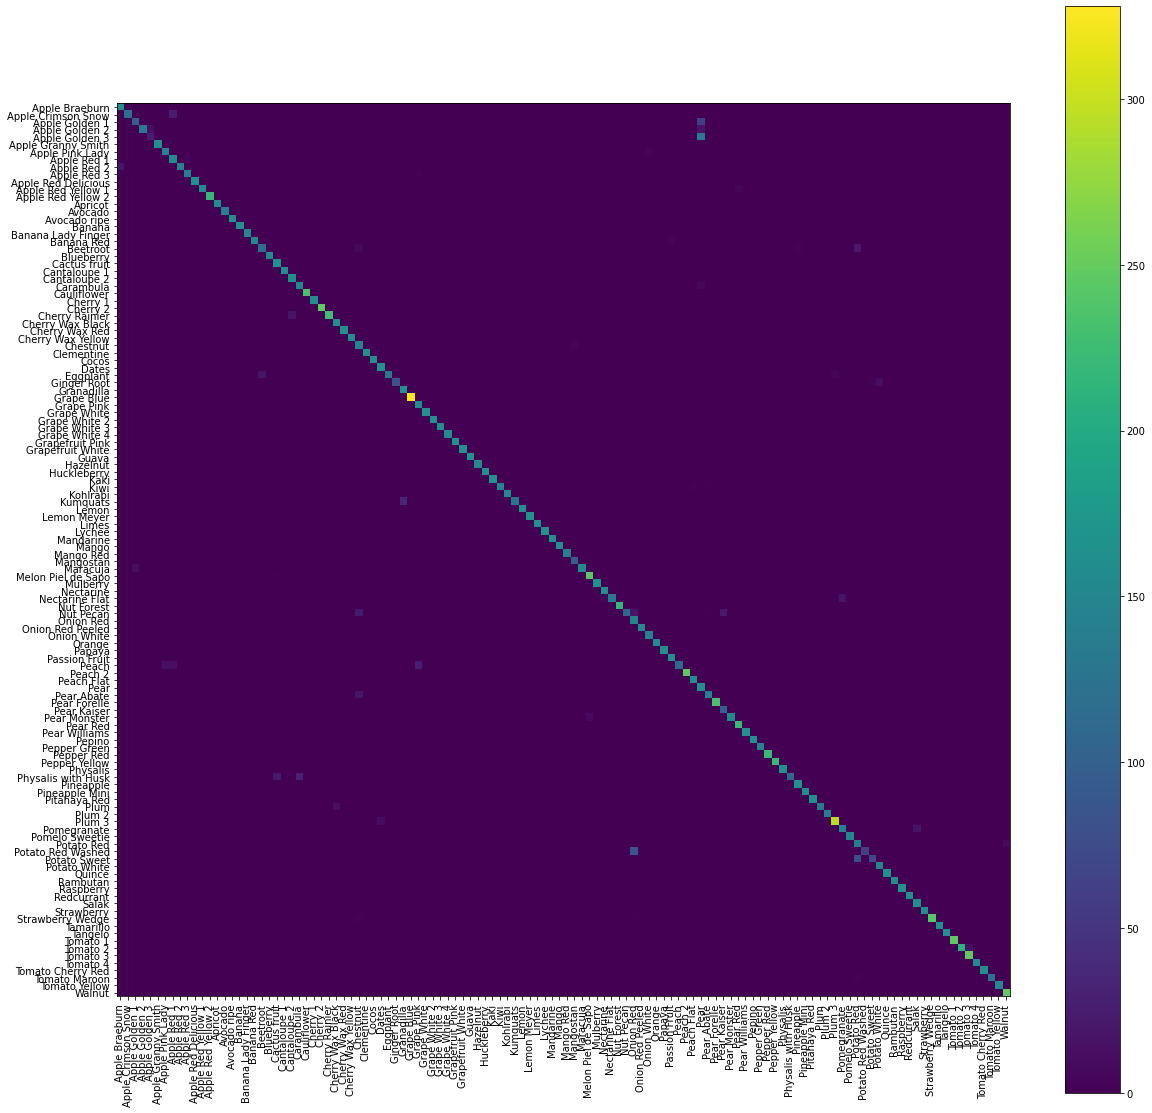

In [44]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
model = load_model('/content/fruits_fresh_cnn_1.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 60486
nb_validation_samples = 20618

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

### Testing our fruit classifier

In [0]:
path

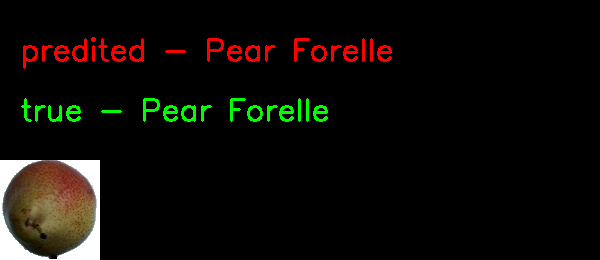

Prediction


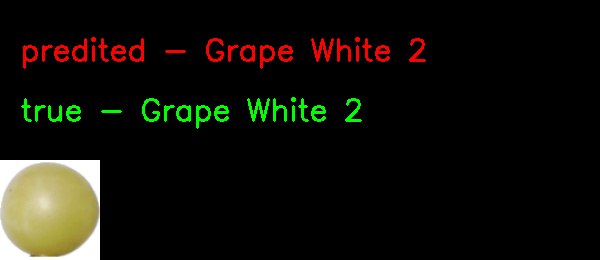

Prediction


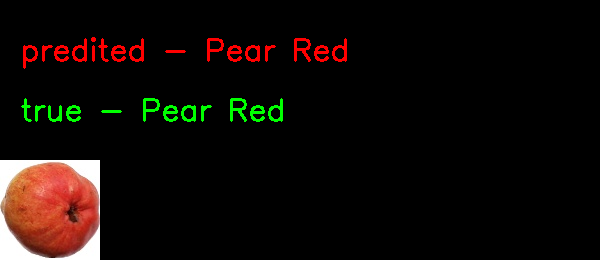

Prediction


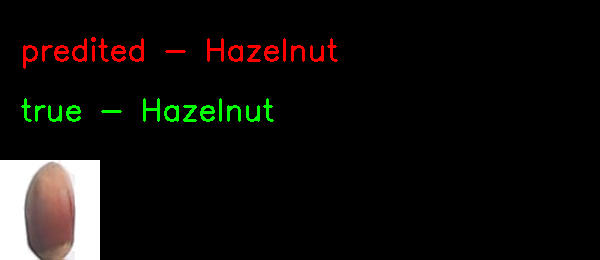

Prediction


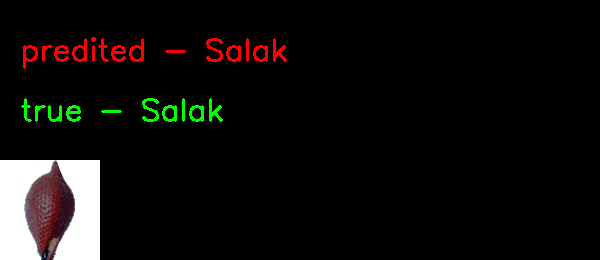

Prediction


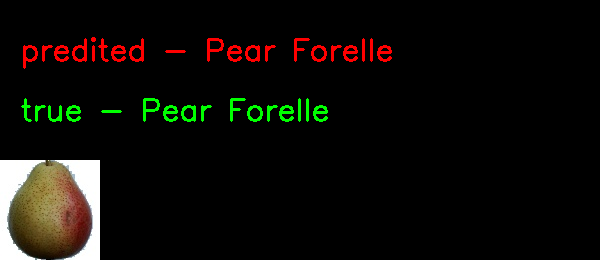

Prediction


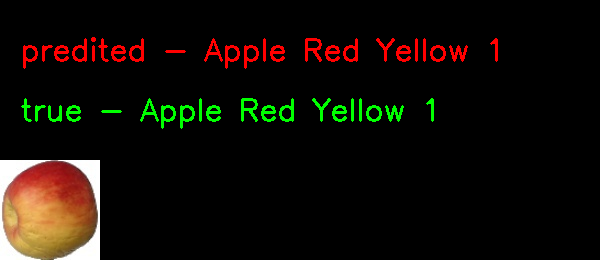

Prediction


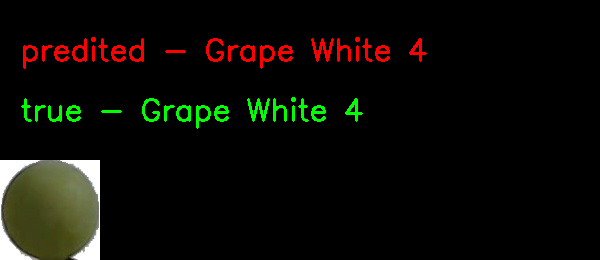

Prediction


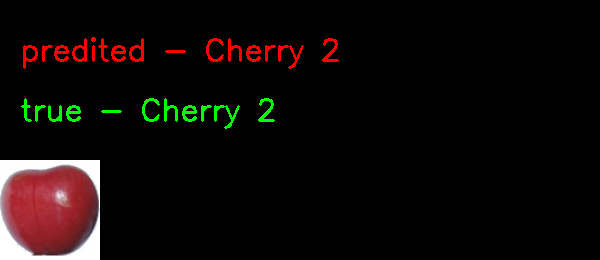

Prediction


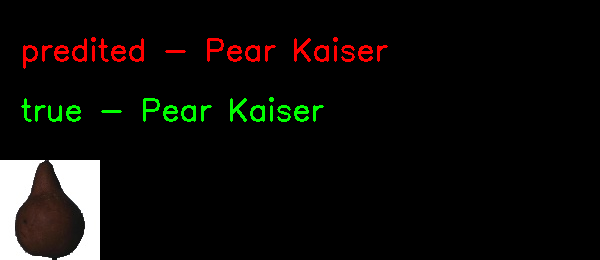

Prediction


In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from google.colab.patches import cv2_imshow

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2_imshow(expanded_image)
    print(name)



def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path +"/"+ path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = '/content/fruits-360/Test' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()